<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter03/Steps_to_build_a_neural_network_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import SGD, Adam
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = '~/data/FMNIST' # This can be any directory you want to 
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

C:\Users\MSI\anaconda3\envs\tf-latest\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [3]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [4]:

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [5]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [6]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [7]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


<ipython-input-9-07f3345cba83>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


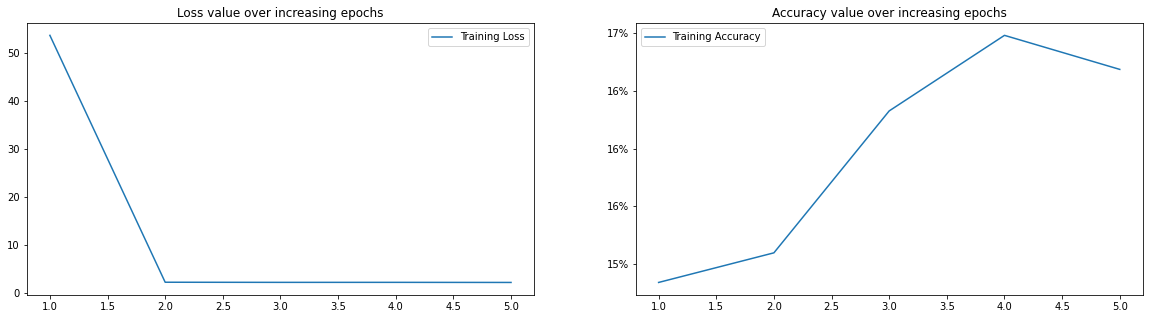

In [9]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

## Scaling a dataset to improve model accuracy


In [10]:
# For this we change FMNISTDataset class, the __init__ part

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 #divide by 255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [11]:
#2. follow all the previous steps
def get_data():
     train = FMNISTDataset(tr_images, tr_targets)
     trn_dl = DataLoader(train, batch_size=32, shuffle=True)
     return trn_dl

In [12]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [14]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() 
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [15]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [16]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


<ipython-input-17-07f3345cba83>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


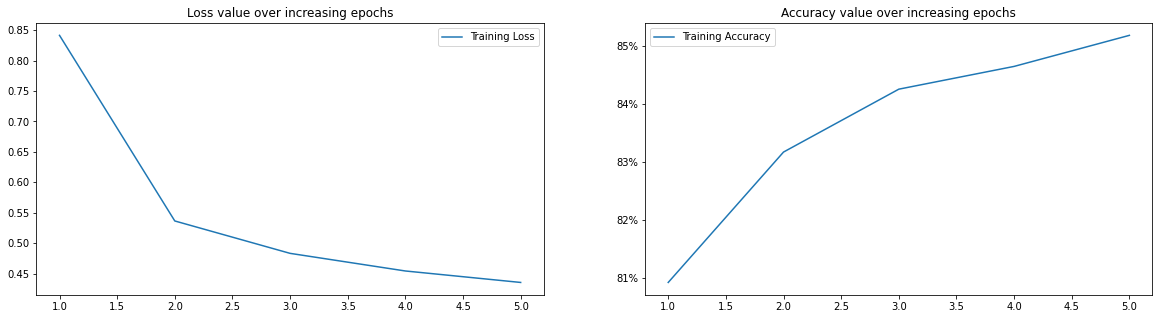

In [17]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

## Understanding the impact of varying the batch size and using a validation dataset


In [18]:
#Before anything, we need to download and import the validation dataset

val_fmnist =datasets.FashionMNIST(data_folder,download=True,train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [19]:
#We do the same process
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 #divide by 255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [20]:
#2. follow all the previous steps
def get_data():
     train = FMNISTDataset(tr_images, tr_targets)
     trn_dl = DataLoader(train, batch_size=32, shuffle=True)
     return trn_dl

In [21]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2) #changed the optimizer
    return model, loss_fn, optimizer

In [22]:
def train_batch(x, y, model, opt, loss_fn):
     model.train()
     prediction = model(x)
     batch_loss = loss_fn(prediction, y)
     batch_loss.backward()
     optimizer.step()
     optimizer.zero_grad()
     return batch_loss.item()

In [23]:
def accuracy(x, y, model):
 model.eval()
 with torch.no_grad():# this is the same as @torch.no_grad at the top of function, only difference being we have to use a 'with'
        prediction = model(x)
 max_values, argmaxes = prediction.max(-1)
 is_correct = argmaxes == y
 return is_correct.cpu().numpy().tolist()

In [24]:
# NOW! the validation dataset. 

def get_data():
    #train
     train = FMNISTDataset(tr_images, tr_targets)
     trn_dl = DataLoader(train, batch_size=32, shuffle=True) # WE CAN CHANGE THIS TO 100000
    #Validation
     val = FMNISTDataset(val_images, val_targets)
     val_dl = DataLoader(val, batch_size=len(val_images),shuffle=False)
     return trn_dl, val_dl

In [25]:
# define a function to calculate the loss of the VALIDATION DATA. This is a different dunction from the training data
@torch.no_grad() #because we are not training the model and only fetching predictions.
def val_loss(x, y, model):
     model.eval()
     prediction = model(x)
     val_loss = loss_fn(prediction, y)
     return val_loss.item()

In [26]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [27]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

In [28]:
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    #loss
    for ix, batch in enumerate(iter(trn_dl)):
         x, y = batch
         batch_loss = train_batch(x, y, model, optimizer, loss_fn)
         train_epoch_losses.append(batch_loss)
         train_epoch_loss = np.array(train_epoch_losses).mean()
    #accuracy
    for ix, batch in enumerate(iter(trn_dl)):
         x, y = batch
         is_correct = accuracy(x, y, model)
         train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    #loss and accuracy on the validation dataset
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4


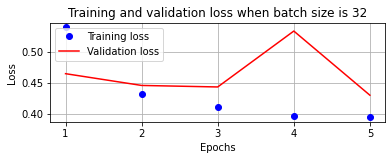

<ipython-input-29-48d2fcd80bd6>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


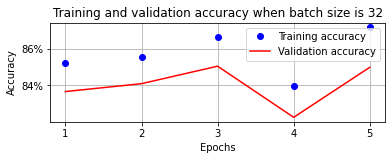

In [29]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline


plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

### With a higher batch size the accuracy drops. That is due to the fact that the weights are updated less times. For example: in this dataset, if we used a batch size of 10,000, the weights would be updated only 6 times. Compare to 32 batch size, the weights would be updated 1,875 times. 

## Understanding the impact of varying the loss optimizer

In [30]:
#Experiment between the SGD and Adam

#for that, we just have to change the get_model function

def get_model():
    model = nn.Sequential(
    nn.Linear(28*28, 1000),
    nn.Relu(),
    nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer =  SGD(model.parameters(), lr = 1e-2)
    return model, loss_fn, optimizer

In [31]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

In [32]:
#increase the number of epochs for comparison

for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    #loss
    for ix, batch in enumerate(iter(trn_dl)):
         x, y = batch
         batch_loss = train_batch(x, y, model, optimizer, loss_fn)
         train_epoch_losses.append(batch_loss)
         train_epoch_loss = np.array(train_epoch_losses).mean()
    #accuracy
    for ix, batch in enumerate(iter(trn_dl)):
         x, y = batch
         is_correct = accuracy(x, y, model)
         train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    #loss and accuracy on the validation dataset
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4
5
6
7
8
9


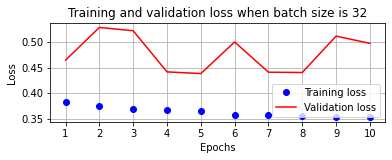

<ipython-input-33-4fcd5802e2c5>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


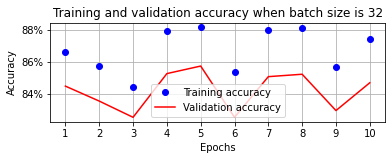

In [33]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline


plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

###### Changes and the effect of those on different learning rates can be found on the book.

## Learning rate reduction

In [35]:
#The scheduler is added to the epoch for loop
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 factor=0.5,
                                                 patience=0,
                                                 verbose=True,
                                                 min_lr= 1e-5,
                                                 threshold_mode='abs')

In [39]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
     print(epoch)
     train_epoch_losses, train_epoch_accuracies = [], []
     for ix, batch in enumerate(iter(trn_dl)):
         x, y = batch
         batch_loss = train_batch(x, y, model, optimizer, loss_fn)
         train_epoch_losses.append(batch_loss)
     train_epoch_loss = np.array(train_epoch_losses).mean()
     for ix, batch in enumerate(iter(trn_dl)):
         x, y = batch
         is_correct = accuracy(x, y, model)
         train_epoch_accuracies.extend(is_correct)
     train_epoch_accuracy = np.mean(train_epoch_accuracies)
     for ix, batch in enumerate(iter(val_dl)):
         x, y = batch
         val_is_correct = accuracy(x, y, model)
         validation_loss = val_loss(x, y, model)
        
         scheduler.step(validation_loss)  #<----- aqui 
            
     val_epoch_accuracy = np.mean(val_is_correct)
     train_losses.append(train_epoch_loss)
     train_accuracies.append(train_epoch_accuracy)
     val_losses.append(validation_loss)
     val_accuracies.append(val_epoch_accuracy)



0
1
2
Epoch     4: reducing learning rate of group 0 to 5.0000e-03.
3
4
5
Epoch     7: reducing learning rate of group 0 to 2.5000e-03.
6
Epoch     8: reducing learning rate of group 0 to 1.2500e-03.
7
8
Epoch    10: reducing learning rate of group 0 to 6.2500e-04.
9
Epoch    11: reducing learning rate of group 0 to 3.1250e-04.
10
Epoch    12: reducing learning rate of group 0 to 1.5625e-04.
11
Epoch    13: reducing learning rate of group 0 to 7.8125e-05.
12
Epoch    14: reducing learning rate of group 0 to 3.9063e-05.
13
Epoch    15: reducing learning rate of group 0 to 1.9531e-05.
14
Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Building a deeper neural network

In [41]:
#we will add another layer to the model

def get_model():
    model = nn.Sequential(nn.Linear(28*28,1000),
                         nn.ReLu(),
                         nn.Linear(1000, 1000), #<----we added a hidden layer
                         nn.ReLu(),
                         nn.Linear(1000, 10)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-3)
    return model, loss_fn, optimizer

## Understanding the impact of batch normalization


In [44]:
# we can use a CLASS for creating a neural network too

def get_model():
    class neuralnet(nn.Module):
        
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)# is 1D  because the output dimension is 1,000 for each image
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)
            
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2 = self.hidden_to_output_layer(x1)
            return x2, x1
        
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-3)
    return model, loss_fn, optimizer

## Impact of adding dropout

In [47]:
def get_model():
     model = nn.Sequential(
     nn.Dropout(0.25),
     nn.Linear(28 * 28, 1000),
     nn.ReLU(),
     nn.Dropout(0.25),
     nn.Linear(1000, 10)
     ).to(device)
     loss_fn = nn.CrossEntropyLoss()
     optimizer = Adam(model.parameters(), lr=1e-3)
     return model, loss_fn, optimizer

## L1 and L2 regularization

In [49]:
#L1 regularization is implemented while training the model, as follows:

def train_batch(x, y, model, opt, loss_fn):
     model.train()
     prediction = model(x)
     l1_regularization = 0 #start with this value
     for param in model.parameters()
        l1_regularization += torch.norm(param,1)
     batch_loss = loss_fn(prediction, y)+0.0001*l1_regularization
     batch_loss.backward()
     optimizer.step()
     optimizer.zero_grad()
     return batch_loss.item()

In [50]:
#for l2 is the same process

def train_batch(x, y, model, opt, loss_fn):
     model.train()
     prediction = model(x)
     l2_regularization = 0
     for param in model.parameters():
         l2_regularization += torch.norm(param,2)
     batch_loss = loss_fn(prediction, y) + 0.01*l2_regularization #the 0.01 value has to be slightly higher than in L1 regularization since the weights are generally 
    #                                                             between -1 to 1 and a square of them would result in even smaller values. 
     batch_loss.backward()
     optimizer.step()
     optimizer.zero_grad()
     return batch_loss.item()
